In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)

Building dataset with constant housing in time


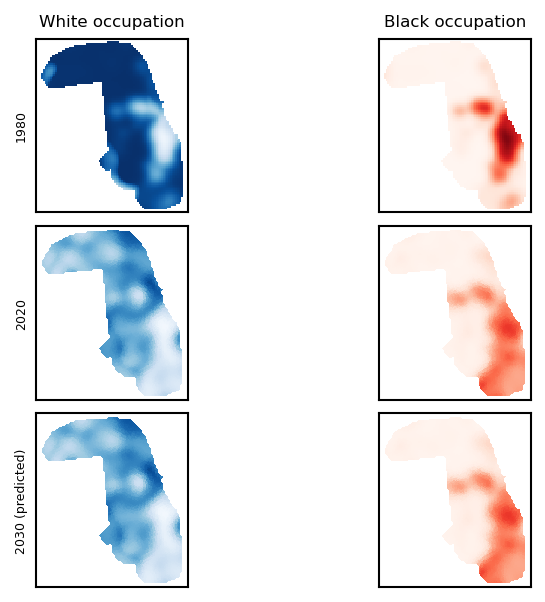

In [4]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

from data_processing import *
from sourced_pbnn import *
from plotting import plot_mesh

dlf.set_log_level(40)

county = 'cook_IL'
dataset = CensusDataset(county, housing_method='constant')
dataset.validate()

fig, ax = plt.subplots(3, 2, dpi=150, sharey=True, sharex=True)

sample = dataset.get_time(1980)
ax[0,0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
ax[0,1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

sample = dataset.get_time(2020, 10)
problem = sample['problem']
w0, b0 = problem.wb0
w1, b1 = problem.forward().split()

plot_mesh(ax[1,0], w0, dataset.mesh, cmap='Blues')
plot_mesh(ax[1,1], b0, dataset.mesh, cmap='Reds')

plot_mesh(ax[2,0], w1, dataset.mesh, cmap='Blues')
plot_mesh(ax[2,1], b1, dataset.mesh, cmap='Reds')

ax[0,0].set_title('White occupation', fontsize=8)
ax[0,1].set_title('Black occupation', fontsize=8)
ax[0,0].set_ylabel('1980')
ax[1,0].set_ylabel('2020')
ax[2,0].set_ylabel('2030 (predicted)')
for a in ax.flatten():
    a.set_aspect('equal')
    a.set(xticks=[], yticks=[])
plt.tight_layout()


In [11]:
import dolfin as dlf
import dolfin_adjoint as d_ad
from tqdm.auto import trange

from sourced_pbnn import DerivativePBNN


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = DerivativePBNN().to(device)

opt = torch.optim.Adam(model.parameters(), lr=3e-4)
sch = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)
idxs = np.arange(len(dataset), dtype=int)
train_loss, val_loss = [], []
step, batch_size, n_epochs = 0, 8, 100

with tqdm(total=n_epochs) as pbar:
    for epoch in range(n_epochs):
        dataset.training()
        np.random.shuffle(idxs)
        d_ad.set_working_tape(d_ad.Tape())

        with tqdm(total=len(dataset), leave=False) as ebar:
            for i in range(len(dataset)):
                batch = dataset[idxs[i]]
                batch['wb0'] = batch['wb0'].to(device)

                params, J = model.training_step(batch)
                train_loss.append(J)
                step += 1
                ebar.update()

                if step % batch_size == 0:
                    ebar.set_postfix(running_loss=np.mean(train_loss[-batch_size:]))

                    opt.step()
                    d_ad.set_working_tape(d_ad.Tape())
                    opt.zero_grad()
                    
        dataset.validate()
        val_loss.append(0)

        with tqdm(total=len(dataset), leave=False) as ebar:
            with torch.no_grad():
                for i in range(len(dataset)):
                    d_ad.set_working_tape(d_ad.Tape())

                    batch = dataset[i]
                    batch['wb0'] = batch['wb0'].to(device)

                    params, J = model.validation_step(batch)
                    val_loss[epoch] += J / len(dataset)
                    ebar.update()
                    
        pbar.set_postfix(val_loss=val_loss[-1])


        torch.save(
            {
                'state_dict': model.state_dict(),
                'val_loss': val_loss,
                'train_loss': train_loss,
            },
            f'{model.__class__.__name__}.ckpt')

        sch.step()
        pbar.update()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

Using vmax = 0
Using vmax = 0


  0%|          | 0/40 [00:00<?, ?it/s]

Using vmax = 0
Difference after 40 years is: 70.8365


Text(0.5, 1.0, '$\\partial_t \\phi_b$')

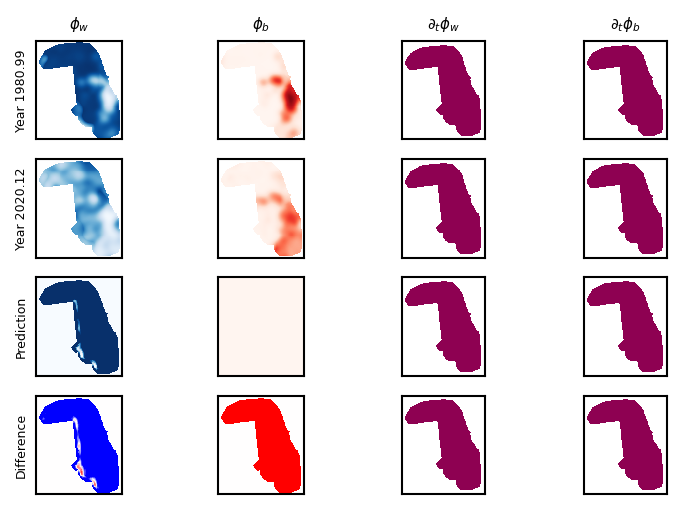

In [14]:
def plot(ax, sample, model, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

    with torch.no_grad(), d_ad.stop_annotating():
        sample['wb0'] = sample['wb0'].to(device)
        problem = sample['problem']
        params = model.forward(sample['wb0'][None],
                               problem.FctSpace,
                               (sample['x'], sample['y']))
        Dij = params['Dij'].detach().cpu().numpy()
        Si  = params['Si'].detach().cpu().numpy()
    
    if vmax is None:
        vmax = np.max(np.abs(Dij))
        print(f'Using vmax = {vmax:g}')

    for i in range(2):
        plot_mesh(ax[2+i], Dij[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_ylabel(f'Year {sample["t"]:g}')
    
    return sample['wb0'].detach().cpu().numpy(), Dij
        
model = DerivativePBNN().to(device)
info = torch.load('PBNN.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1
fig, ax = plt.subplots(4, 4, dpi=150)
wb0, Dij0 = plot(ax[0], dataset[0], model)
wb1, Dij1 = plot(ax[1], dataset[tmax], model);


sample = dataset.get_time(t0, dt=dt)
sample['wb0'] = torch.FloatTensor(sample['wb0'])
mask = sample['mask']

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

wb2, Dij2 = plot(ax[2], sample, model)
print(f'Difference after {tmax} years is: {np.mean((wb1[:, mask]-wb2[:, mask])**2):g}')

diff = wb1 - wb2
vmax = 3*np.std(diff[:, mask])
vmax = 1
ax[3, 0].pcolormesh(sample['x'], sample['y'], diff[0], cmap='bwr', vmin=-vmax, vmax=vmax)
ax[3, 1].pcolormesh(sample['x'], sample['y'], diff[1], cmap='bwr', vmin=-vmax, vmax=vmax)
diff = Dij1 - Dij0
vmax = 3*np.std(diff)
for i in range(2):
    plot_mesh(ax[3, 2+i], diff[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
for a in ax[3]:
    a.set(aspect='equal', xticks=[], yticks=[])
ax[3, 0].set_ylabel('Difference')

ax[2,0].set_ylabel('Prediction')

ax[0,0].set_title('$\\phi_w$')
ax[0,1].set_title('$\\phi_b$')
ax[0,2].set_title('$\\partial_t \phi_w$')
ax[0,3].set_title('$\\partial_t \phi_b$')

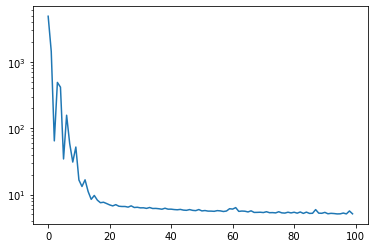

In [58]:
plt.semilogy(info['val_loss'])